<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/subprocess32.py:472: RuntimeWarning: The _posixsubprocess module is not being used. Child process reliability may suffer if your program uses threads.
  "program uses threads.", RuntimeWarning)


last updated: 2017-05-15 

CPython 2.7.13
IPython 5.3.0

numpy 1.12.1
matplotlib 2.0.1
scipy 0.19.0
pandas 0.19.2
sklearn 0.18.1
mlxtend 0.6.0


In [2]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns
from sklearn.metrics import accuracy_score

import comptools as comp
import comptools.analysis.plotting as plotting
    
color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.virtualenvs/icecube/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
config = 'IC79'
# config = 'IC86.2012'
comp_list = ['light', 'heavy']
pipeline_str = 'GBDT'
feature_list, feature_labels = comp.get_training_features()

In [4]:
sim_df_train, sim_df_test = comp.load_dataframe(datatype='sim', config=config)
pipeline = comp.get_pipeline(pipeline_str)

Starting out with 398044 events
sim quality cut event flow:
      passed_IceTopQualityCuts:    1.0    1.0
FractionContainment_Laputop_InIce:  0.776  0.776
       passed_InIceQualityCuts:  0.786   0.75
                 num_hits_1_60:  0.999   0.75




In [6]:
X_train, y_train = comp.dataframe_to_X_y(sim_df_train, feature_list)
X_test, y_test = comp.dataframe_to_X_y(sim_df_test, feature_list)

In [7]:
clf_name = pipeline.named_steps['classifier'].__class__.__name__
print('=' * 30)
print(clf_name)

pipeline = pipeline.fit(X_train, y_train)
train_pred = pipeline.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
print('Training accuracy = {:.2%}'.format(train_acc))

test_pred = pipeline.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print('Testing accuracy = {:.2%}'.format(test_acc))

print('=' * 30)

GradientBoostingClassifier
Training accuracy = 76.21%
Testing accuracy = 75.56%


In [21]:
light_mask = sim_df_train['MC_comp_class'] == 'light'
heavy_mask = sim_df_train['MC_comp_class'] == 'heavy'
null_mask = ~sim_df_train['refit_beta'].isnull()
energy_mask = (sim_df_train['log_s125'] > 1.9) & (sim_df_train['log_s125'] <= 2.1)
zenith_mask = (sim_df_train['lap_cos_zenith'] > 0.9) & (sim_df_train['lap_cos_zenith'] <= 1.0)
radius_mask = (sim_df_train['avg_inice_radius_1_60'] > 120) & (sim_df_train['avg_inice_radius_1_60'] <= 130)

In [22]:
null_mask.sum()/len(null_mask)

1.0

In [23]:
feature_dict =  {'log_s125': 2.0, 'lap_cos_zenith': 0.95}

In [ ]:
g = sns.JointGrid(x=sim_train_df['log_dEdX'][light_mask & energy_mask],
                  y=sim_train_df['avg_inice_radius_1_60'][light_mask & energy_mask],
                  xlim=(1.5, 2.75), ylim=(100, 160), space=0)


plotting.plot_decision_slice('log_dEdX', 'avg_inice_radius_1_60', sim_train_df[feature_list], pipeline,
                             filler_feature_dict=feature_dict, xres=0.02, yres=0.02, colors=['C0', 'C1'],
                             ax=g.ax_joint)


light_contour = sns.kdeplot(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask],
            sim_train_df['avg_inice_radius_1_60'][light_mask & energy_mask & zenith_mask],
            cmap='Blues', label='light', ax=g.ax_joint)
#             cmap='Blues', label='light', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
dE_dX_bins = np.linspace(1.5, 2.75, 50)
inice_radius_bins = np.linspace(100, 160, 50)
_ = g.ax_marg_x.hist(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=dE_dX_bins, label='light')
_ = g.ax_marg_y.hist(sim_train_df['avg_inice_radius_1_60'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=inice_radius_bins, orientation="horizontal")


g.x = sim_train_df['log_dEdX'][heavy_mask & energy_mask]
g.y = sim_train_df['avg_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask]
# g = g.plot_joint(sns.kdeplot, cmap='Oranges', label='heavy')
heavy_contour = sns.kdeplot(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask],
            sim_train_df['avg_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask],
            cmap='Oranges', label='heavy', ax=g.ax_joint)
#             cmap='Oranges', label='heavy', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
_ = g.ax_marg_x.hist(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=dE_dX_bins, label='heavy')
_ = g.ax_marg_y.hist(sim_train_df['avg_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=inice_radius_bins, orientation="horizontal")

g.ax_joint.grid()
g.ax_marg_x.grid(axis='x')
g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -0.5),
           frameon=False, ncol=1)
g.ax_marg_y.grid(axis='y')

g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(dE/dX)}$')
g.ax_joint.set_ylabel('$\mathrm{\langle R_{\mu}\\rangle }$')
g.ax_joint.text(1.575, 155, '$\mathrm{ 1.5 < \\log_{10}(S_{125}) \leq 1.75 }$', fontsize=12)
# g.ax_joint.text(1.575, 155, '$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) \leq 7.6 }$', fontsize=12)
g.ax_joint.text(1.575, 151, '$\mathrm{ 0.9 < \cos(\\theta_{reco}) \leq 1.0 }$', fontsize=12)

g.savefig('/home/jbourbeau/public_html/figures/avg_inice_radius-vs-dEdX-contours.png')

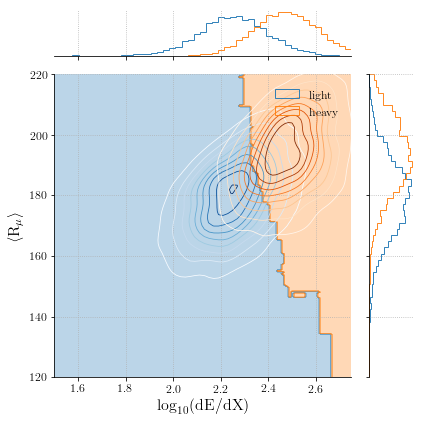

In [24]:
g = sns.JointGrid(x=sim_df_train['log_dEdX'][light_mask & energy_mask],
                  y=sim_df_train['invqweighted_inice_radius_1_60'][light_mask & energy_mask],
                  xlim=(1.5, 2.75), ylim=(120, 220), space=0)


plotting.plot_decision_slice('log_dEdX', 'invqweighted_inice_radius_1_60', sim_df_train[feature_list], pipeline,
                             filler_feature_dict=feature_dict, xres=0.01, yres=0.5, colors=['C0', 'C1'],
                             ax=g.ax_joint)


light_contour = sns.kdeplot(sim_df_train['log_dEdX'][light_mask & energy_mask & zenith_mask],
            sim_df_train['invqweighted_inice_radius_1_60'][light_mask & energy_mask & zenith_mask],
            cmap='Blues', label='light', ax=g.ax_joint)
#             cmap='Blues', label='light', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
dE_dX_bins = np.linspace(1.5, 2.75, 50)
inice_radius_bins = np.linspace(120, 220, 50)
_ = g.ax_marg_x.hist(sim_df_train['log_dEdX'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=dE_dX_bins, label='light')
_ = g.ax_marg_y.hist(sim_df_train['invqweighted_inice_radius_1_60'][light_mask & energy_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=inice_radius_bins, orientation="horizontal")


g.x = sim_df_train['log_dEdX'][heavy_mask & energy_mask & zenith_mask]
g.y = sim_df_train['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask]
# g = g.plot_joint(sns.kdeplot, cmap='Oranges', label='heavy')
heavy_contour = sns.kdeplot(sim_df_train['log_dEdX'][heavy_mask & energy_mask & zenith_mask],
            sim_df_train['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask],
            cmap='Oranges', label='heavy', ax=g.ax_joint)
#             cmap='Oranges', label='heavy', shade=True, shade_lowest=False, alpha=0.5, ax=g.ax_joint)
_ = g.ax_marg_x.hist(sim_df_train['log_dEdX'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=dE_dX_bins, label='heavy')
_ = g.ax_marg_y.hist(sim_df_train['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=inice_radius_bins, orientation="horizontal")

g.ax_joint.grid()
g.ax_marg_x.grid(axis='x')
g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -0.5),
           frameon=False, ncol=1)
g.ax_marg_y.grid(axis='y')

# g.ax_joint.scatter(sim_train_df['log_dEdX'][light_mask & energy_mask & zenith_mask],
#                    sim_train_df['invqweighted_inice_radius_1_60'][light_mask & energy_mask & zenith_mask],
#                    color='C0', alpha=0.02)
# g.ax_joint.scatter(sim_train_df['log_dEdX'][heavy_mask & energy_mask & zenith_mask],
#                    sim_train_df['invqweighted_inice_radius_1_60'][heavy_mask & energy_mask & zenith_mask],
#                    color='C1', alpha=0.02)

g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(dE/dX)}$')
g.ax_joint.set_ylabel('$\mathrm{\langle R_{\mu}\\rangle }$')
# g.ax_joint.text(1.575, 155, '$\mathrm{ 1.5 < \\log_{10}(S_{125}) \leq 1.75 }$', fontsize=12)
# # g.ax_joint.text(1.575, 155, '$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) \leq 7.6 }$', fontsize=12)
# g.ax_joint.text(1.575, 151, '$\mathrm{ 0.9 < \cos(\\theta_{reco}) \leq 1.0 }$', fontsize=12)

g.savefig('/home/jbourbeau/public_html/figures/avg_inice_radius-vs-dEdX-contours.png')

In [15]:
feature_dict =  {'avg_inice_radius_1_60': 125, 'lap_cos_zenith': 0.95}

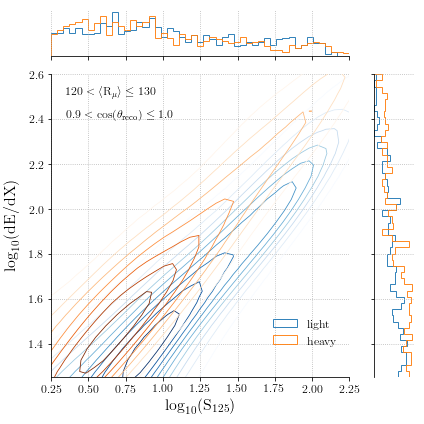

In [16]:
g = sns.JointGrid(y=sim_train_df['log_dEdX'][light_mask & energy_mask],
                  x=sim_train_df['log_s125'][light_mask & energy_mask],
                  ylim=(1.25, 2.6), xlim=(0.25, 2.25), space=0)


# g.ax_joint = plotting.plot_decision_region('log_s125', 'log_dEdX', feature_list, sim_train_df, pipeline,
#                               filler_values_dict=feature_dict, xres=0.02, yres=0.02, ax=g.ax_joint)


light_contour = sns.kdeplot(sim_train_df['log_s125'][light_mask & radius_mask & zenith_mask],
            sim_train_df['log_dEdX'][light_mask & radius_mask & zenith_mask],
            cmap='Blues', label='light', ax=g.ax_joint)

dE_dX_bins = np.linspace(1.25, 2.6, 50)
s125_bins = np.linspace(0.25, 2.25, 50)
_ = g.ax_marg_x.hist(sim_train_df['log_s125'][light_mask & radius_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=s125_bins, label='light')
_ = g.ax_marg_y.hist(sim_train_df['log_dEdX'][light_mask & radius_mask & zenith_mask], histtype='step',
                     color='C0', alpha=.9, bins=dE_dX_bins, orientation="horizontal")


g.y = sim_train_df['log_dEdX'][heavy_mask & radius_mask]
g.x = sim_train_df['log_s125'][heavy_mask & radius_mask & zenith_mask]
heavy_contour = sns.kdeplot(sim_train_df['log_s125'][heavy_mask & radius_mask & zenith_mask],
            sim_train_df['log_dEdX'][heavy_mask & radius_mask & zenith_mask],
            cmap='Oranges', label='heavy', ax=g.ax_joint)

_ = g.ax_marg_x.hist(sim_train_df['log_s125'][heavy_mask & radius_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=s125_bins, label='heavy')
_ = g.ax_marg_y.hist(sim_train_df['log_dEdX'][heavy_mask & radius_mask & zenith_mask], histtype='step',
                     color='C1', alpha=.9, bins=dE_dX_bins, orientation="horizontal")

g.ax_joint.grid()
g.ax_marg_x.grid(axis='x')
g.ax_marg_x.legend(loc='upper center', bbox_to_anchor=(0.85, -5.5),
           frameon=False, ncol=1)
g.ax_marg_y.grid(axis='y')

g.ax_joint.set_ylabel('$\mathrm{\\log_{10}(dE/dX)}$')
g.ax_joint.set_xlabel('$\mathrm{\\log_{10}(S_{125})}$')
g.ax_joint.text(0.35, 2.5, '$\mathrm{ 120 < \langle R_{\mu}\\rangle \leq 130 }$', fontsize=12)
g.ax_joint.text(0.35, 2.4, '$\mathrm{ 0.9 < \cos(\\theta_{reco}) \leq 1.0 }$', fontsize=12)

g.savefig('/home/jbourbeau/public_html/figures/dEdX-vs-s125-contours.png')

In [25]:
sim_train_df.log_s125.plot(kind='hist', bins=50)
plt.show()

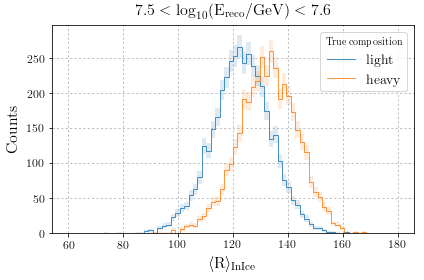

In [18]:
radius_bins = np.linspace(60, 180, 75)

fig, ax = plt.subplots()

# df_sim['log_dEdX'][light_mask & energy_mask].plot(kind='hist', bins=bins, alpha=0.75, label='light', ax=ax)
# df_sim['log_dEdX'][heavy_mask & energy_mask].plot(kind='hist', bins=bins, alpha=0.75, label='heavy', ax=ax)

light_counts = np.histogram(df_sim['avg_inice_radius'][light_mask & energy_mask], radius_bins)[0]
heavy_counts = np.histogram(df_sim['avg_inice_radius'][heavy_mask & energy_mask], radius_bins)[0]

plotting.plot_steps(radius_bins, light_counts, yerr=np.sqrt(light_counts), ax=ax, color='C0', label='light')
plotting.plot_steps(radius_bins, heavy_counts, yerr=np.sqrt(heavy_counts), ax=ax, color='C1', label='heavy')

# ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('Counts')
ax.set_xlabel('$\mathrm{\langle R \\rangle _{InIce}}$')
ax.set_title('$\mathrm{ 7.5 < \\log_{10}(E_{reco}/GeV) < 7.6 }$')
# ax.set_xlim([70, 170])
ax.set_ylim(0)
ax.grid()
ax.legend(title='True composition')
plt.savefig('/home/jbourbeau/public_html/figures/avg-radius-dist-example.png')
plt.show()

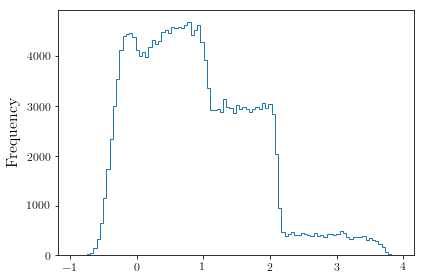

In [14]:
sim_df_train.log_s125.plot(kind='hist', bins=100, histtype='step');